# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

In [5]:
display_df(data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Index data by Date
data['Date'] = pd.to_datetime(data['Date'])

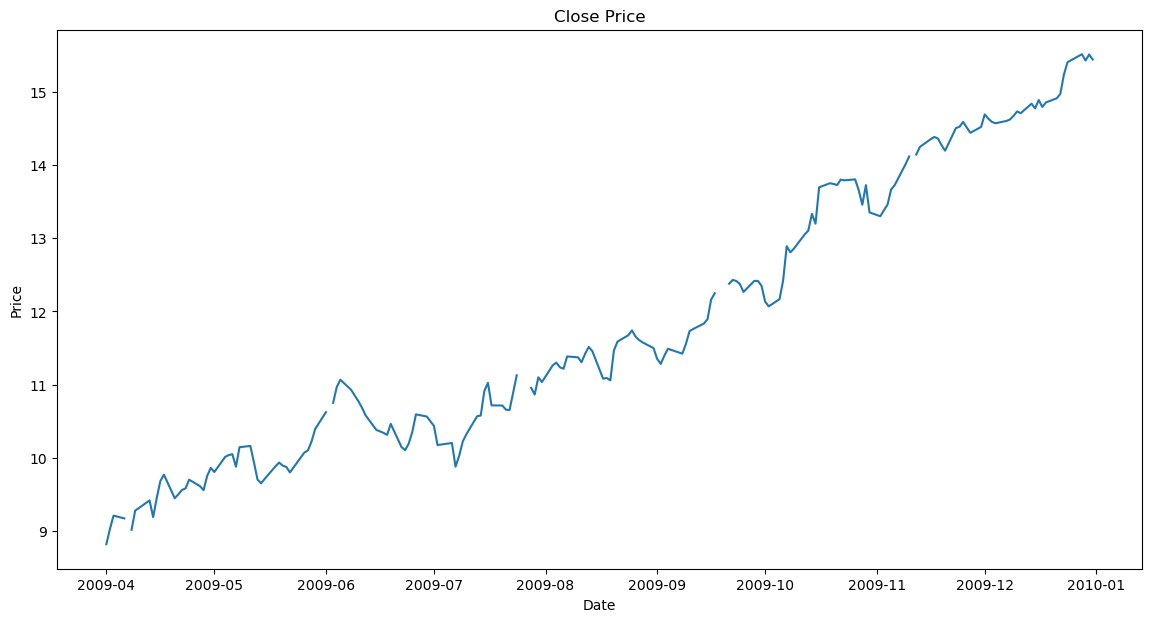

In [9]:
# Plot the Close Data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [10]:
# Check for null values
data.isnull().sum()

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [13]:
# forward fill missing values
data.ffill(inplace=True)

In [14]:
# Check for null values
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

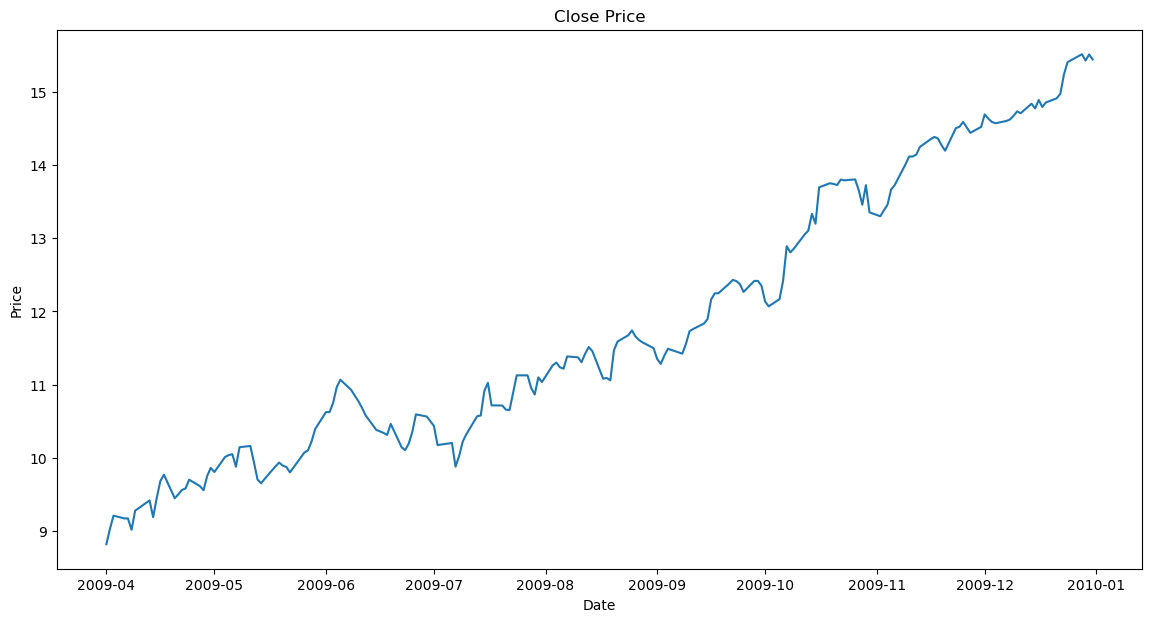

In [15]:
# Plot the cleaned Close Data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [18]:
# Calculate 20-day bollinger bands
data['20_day_sma'] = data['Close'].rolling(window=20).mean()
data['20_day_std'] = data['Close'].rolling(window=20).std()
data['Upper_band'] = data['20_day_sma'] + (data['20_day_std'] * 2)
data['Lower_band'] = data['20_day_sma'] - (data['20_day_std'] * 2)


In [20]:
data.head(25)

,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0,NaN,NaN,NaN,NaN
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0,NaN,NaN,NaN,NaN
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0,NaN,NaN,NaN,NaN
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
4,2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0,NaN,NaN,NaN,NaN
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0,NaN,NaN,NaN,NaN
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0,NaN,NaN,NaN,NaN
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0,NaN,NaN,NaN,NaN
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0,NaN,NaN,NaN,NaN


In [21]:
# Remove rows with NaN bollinger bands 
data.dropna(inplace=True)

In [22]:
data.head(25)

,Date,Open,High,Low,Close,Adj Close,Volume,20_day_sma,20_day_std,Upper_band,Lower_band
19,2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
20,2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
21,2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
22,2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
23,2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898
24,2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.614014,0.275700,10.165415,9.062614
25,2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.657115,0.242734,10.142584,9.171646
26,2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,9.700490,0.248804,10.198098,9.202882
27,2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,9.737688,0.259638,10.256965,9.218412
28,2009-05-12,10.211973,10.236382,9.840864,9.938000,9.938000,152200354.0,9.775173,0.228385,10.231943,9.318403


In [23]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper_band', 'Lower_band']]
dataset.head()

,Close,Upper_band,Lower_band
19,9.750204,9.937823,8.853717
20,9.862284,9.956057,8.939792
21,9.805497,9.978454,8.995079
22,10.011973,10.053107,9.000625
23,10.037128,10.115385,9.024898


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [24]:
# Display & Plot Un-normalized Dataset

In [25]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[col].values.reshape(-1, 1)
    # fit normalizer to column data
    normalizer.fit(column_data)
    # transform column data with the fitted normalizer, and place the transformed data column in out normed_dataset df
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    # append the fitted normalizer to normlist for use later
    normlist.append(normalizer)
    


,Close,Upper_band,Lower_band
19,-1.341805,-1.450150,-1.430416
20,-1.277192,-1.439244,-1.377255
21,-1.309929,-1.425848,-1.343109
22,-1.190897,-1.381197,-1.339683
23,-1.176395,-1.343949,-1.324692


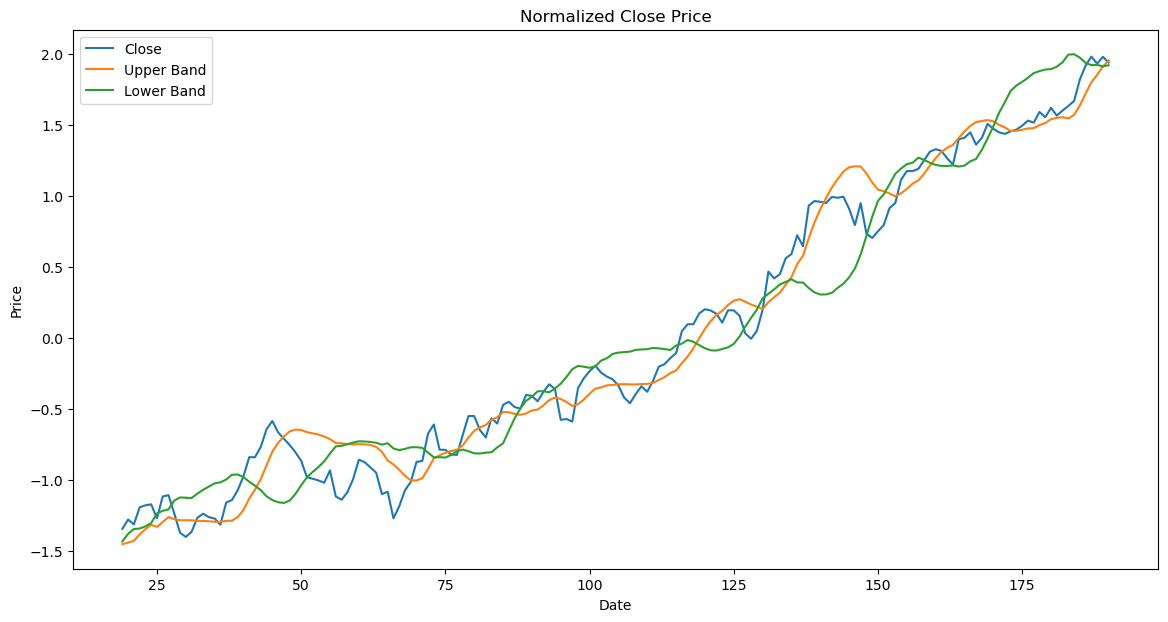

In [26]:
# Display & Plot Normalized Dataset
display_df(normed_dataset.head())
plt.figure(figsize=(14, 7))
plt.plot(normed_dataset.index, normed_dataset['Close'], label='Close')
plt.plot(normed_dataset.index, normed_dataset['Upper_band'], label='Upper Band')
plt.plot(normed_dataset.index, normed_dataset['Lower_band'], label='Lower Band')
plt.title('Normalized Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()  

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [ ]:
# split dataset df into train (50%) and test (50%) datasets
train_df = 
test_df =  # define testing dtaframe under this variable name